In [10]:
import pandas as pd
from IPython.display import HTML

#Практика N6 "Задача коммивояжера".


##  Формулировка

**Задача коммивояжёра** состоит в том, чтобы найти кратчайший путь, проходящий через каждый из заданных городов ровно один раз и возвращающийся в исходный город.

---

##  Входные данные

- **Множество городов**: $ V = \{0, 1, 2, ..., N-1\} $
- **Матрица расстояний**: $ D = [d_{ij}] $, где $ d_{ij} $ — расстояние от города \( i \) до города \( j \)

---

##  Цель

Найти маршрут минимальной длины, проходящий через все города по одному разу и замыкающийся в начальном пункте.

---

##  MTZ-ограничения (Миллера — Такера — Землина)
###  Обозначения переменных:

-  $x_{ij} \in \{0, 1\}$  — бинарная переменная:  
  принимает значение **1**, если маршрут проходит **из города \( i \) в город \( j \)**; иначе — 0.

- $\{ u_i \in \mathbb{R} \}$ — порядковый номер посещения города \( i \) в туре:  
  используется для **исключения подциклов** при помощи MTZ-ограничений.
###  Формула MTZ-ограничений:

$
u_i - u_j + N \cdot x_{ij} \geq 1,\quad \forall\ i \ne j,\ i, j \in \{1, 2, ..., N-1\}
$

Это условие устраняет подциклы в частичных маршрутах, запрещая решения, содержащие неполные туры.

---

###  Диапазоны значений:

- $ u_i \in [1, N-1] $, для $ i = 1, ..., N-1 $
- $ u_0 = 0 $ — фиксируем значение для первого города

---

###  Логика:

- Если $ x_{ij} = 1 $, то $ u_j \geq u_i + 1 $, то есть следующий город должен иметь более высокий порядок
- Если $ x_{ij} = 0 $, то не накладывается ограничений между $ u_i $ и $ u_j $

---

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import milp, LinearConstraint, Bounds
import itertools

# --- 1. Заданные данные: Матрица расстояний для 6 городов ---
dist_matrix_given_6_cities = np.array([
    [0, 20, 30, 10, 40, 50],
    [20, 0, 18, 25, 30, 40],
    [30, 18, 0, 15, 20, 35],
    [10, 25, 15, 0, 22, 30],
    [40, 30, 20, 22, 0, 10],
    [50, 40, 35, 30, 10, 0]
])

N = dist_matrix_given_6_cities.shape[0] # Количество городов = 6

print("Заданная матрица расстояний (6 городов):")
print(dist_matrix_given_6_cities)



Заданная матрица расстояний (6 городов):
[[ 0 20 30 10 40 50]
 [20  0 18 25 30 40]
 [30 18  0 15 20 35]
 [10 25 15  0 22 30]
 [40 30 20 22  0 10]
 [50 40 35 30 10  0]]


In [12]:
# --- 2. Формулировка задачи ILP для TSP с MTZ ---

num_x_vars = N * N
num_u_vars = N - 1 # u_i для городов 1..N-1
num_total_vars = num_x_vars + num_u_vars

# Целевая функция: минимизировать сумму d_ij * x_ij
c = np.zeros(num_total_vars)
for i in range(N):
    for j in range(N):
        if i != j:
            var_idx = i * N + j
            c[var_idx] = dist_matrix_given_6_cities[i, j]

# --- Ограничения (все >= 1) ---
constraints_A_rows = []
constraints_b_values = []
print(c)

[ 0. 20. 30. 10. 40. 50. 20.  0. 18. 25. 30. 40. 30. 18.  0. 15. 20. 35.
 10. 25. 15.  0. 22. 30. 40. 30. 20. 22.  0. 10. 50. 40. 35. 30. 10.  0.
  0.  0.  0.  0.  0.]


In [13]:
# 2. Из каждого города выезжает ровно одна дорога (sum_j x_ij = 1)
for i in range(N):
    row = np.zeros(num_total_vars)
    for j in range(N):
        if i != j:
            var_idx = i * N + j
            row[var_idx] = 1
    constraints_A_rows.append(row)
    constraints_b_values.append(1)
for i in range(len(constraints_A_rows)):
    for j in range(len(constraints_A_rows[i])):
        print(int(constraints_A_rows[i][j]), end= '')
    print()

print(constraints_b_values)

01111100000000000000000000000000000000000
00000010111100000000000000000000000000000
00000000000011011100000000000000000000000
00000000000000000011101100000000000000000
00000000000000000000000011110100000000000
00000000000000000000000000000011111000000
[1, 1, 1, 1, 1, 1]


In [14]:
# 3. В каждый город приезжает ровно одна дорога (sum_i x_ij = 1)
for j in range(N):
    row = np.zeros(num_total_vars)
    for i in range(N):
        if i != j:
            var_idx = i * N + j
            row[var_idx] = 1
    constraints_A_rows.append(row)
    constraints_b_values.append(1)
for i in range(len(constraints_A_rows)):
    for j in range(len(constraints_A_rows[i])):
        print(int(constraints_A_rows[i][j]), end= '')
    print()

print(constraints_b_values)

01111100000000000000000000000000000000000
00000010111100000000000000000000000000000
00000000000011011100000000000000000000000
00000000000000000011101100000000000000000
00000000000000000000000011110100000000000
00000000000000000000000000000011111000000
00000010000010000010000010000010000000000
01000000000001000001000001000001000000000
00100000100000000000100000100000100000000
00010000010000010000000000010000010000000
00001000001000001000001000000000001000000
00000100000100000100000100000100000000000
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [15]:

# 4. MTZ ограничения: u_i - u_j + N * x_ij >= 1 (для i, j от 1 до N-1, i != j)
# Индексы городов для u: 1..N-1 (в Python это индексы 1..N-1)
for i_idx in range(1, N): # Города 1..N-1
    for j_idx in range(1, N): # Города 1..N-1
        if i_idx != j_idx:
            row = np.zeros(num_total_vars)
            # u_i: индекс N*N + (i_idx - 1)
            var_u_i_idx = num_x_vars + (i_idx - 1)
            # u_j: индекс N*N + (j_idx - 1)
            var_u_j_idx = num_x_vars + (j_idx - 1)
            # x_ij: индекс i_idx * N + j_idx
            var_x_ij_idx = i_idx * N + j_idx

            row[var_u_i_idx] = 1
            row[var_u_j_idx] = -1
            row[var_x_ij_idx] = N

            constraints_A_rows.append(row)
            constraints_b_values.append(1) # >= 1

# --- Типы переменных ---
integrality = np.zeros(num_total_vars)
integrality[:num_x_vars] = 1 # x_ij - бинарные
integrality[num_x_vars:] = 1 # u_i - целочисленные

# --- Пределы для переменных (Bounds) ---
low_bounds = np.zeros(num_total_vars)
up_bounds = np.ones(num_total_vars)

low_bounds[num_x_vars:] = 1 # Нижняя граница для u_i = 1
up_bounds[num_x_vars:] = N  # Верхняя граница для u_i = N

bounds = Bounds(lb=low_bounds, ub=up_bounds)

# --- Создание объекта LinearConstraint ---
A_all = np.array(constraints_A_rows)
b_all = np.array(constraints_b_values)
linear_constraint = LinearConstraint(A_all, lb=b_all)

for i in range(len(A_all)):
    for j in range(len(A_all[i])):
        print(int(A_all[i][j]), end= '')
    print()

print(b_all)
print('integrality',integrality)
print('low_bounds',low_bounds)
print('up_bounds', up_bounds)

01111100000000000000000000000000000000000
00000010111100000000000000000000000000000
00000000000011011100000000000000000000000
00000000000000000011101100000000000000000
00000000000000000000000011110100000000000
00000000000000000000000000000011111000000
00000010000010000010000010000010000000000
01000000000001000001000001000001000000000
00100000100000000000100000100000100000000
00010000010000010000000000010000010000000
00001000001000001000001000000000001000000
00000100000100000100000100000100000000000
0000000060000000000000000000000000001-1000
00000000060000000000000000000000000010-100
000000000060000000000000000000000000100-10
0000000000060000000000000000000000001000-1
000000000000060000000000000000000000-11000
00000000000000060000000000000000000001-100
000000000000000060000000000000000000010-10
0000000000000000060000000000000000000100-1
000000000000000000060000000000000000-10100
0000000000000000000060000000000000000-1100
000000000000000000000060000000000000001-10
00000000000000000000000


Решение задачи коммивояжера (6 городов, заданные расстояния)...

--- Результаты ---
Статус решения: 0

Оптимальное решение найдено.
Кратчайший маршрут: [0, 3, 1, 2, 5, 4, 0]
Общая длина маршрута: 275.00


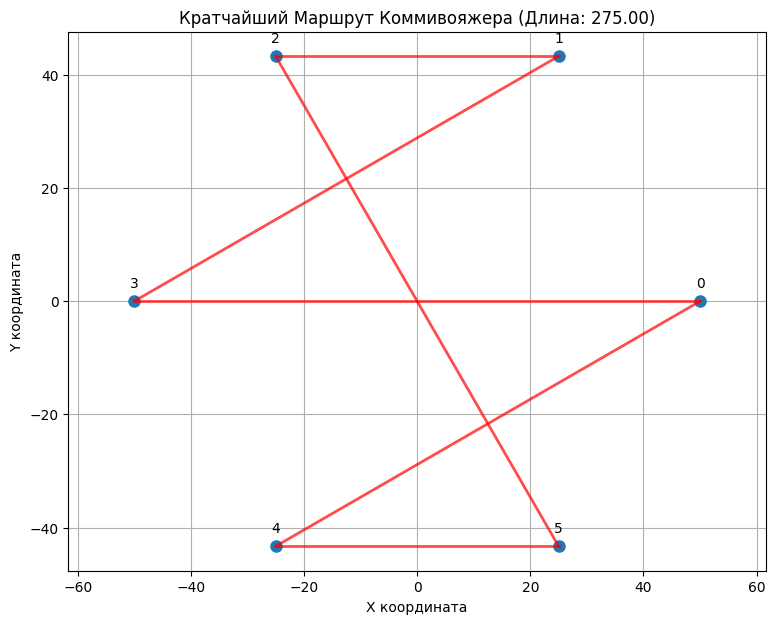

In [16]:
# --- 3. Решение задачи MILP ---
print("\nРешение задачи коммивояжера (6 городов, заданные расстояния)...")
result = milp(c=c,
              constraints=linear_constraint,
              integrality=integrality,
              bounds=bounds)

# --- 4. Обработка и вывод результатов ---
print("\n--- Результаты ---")
print("Статус решения:", result.status)

if result.success:
    print("\nОптимальное решение найдено.")

    # Извлечение вектора x_ij
    x_vars = result.x[:num_x_vars].reshape((N, N))
    # Извлечение вектора u_i
    u_vars = result.x[num_x_vars:]

    # --- Восстановление маршрута ---
    route = []
    current_city = 0 # Начинаем с города 0
    visited = [False] * N

    route.append(current_city)
    visited[current_city] = True

    # Находим следующий город, пока не посетим все N городов
    for _ in range(N - 1): # Идем N-1 шагов, чтобы посетить остальные города
        found_next = False
        for next_city in range(N):
            # Ищем x_current_city, next_city = 1 и next_city еще не посещен
            if np.isclose(x_vars[current_city, next_city], 1) and not visited[next_city]:
                current_city = next_city
                route.append(current_city)
                visited[current_city] = True
                found_next = True
                break
        # Если не нашли следующий город (не должно произойти при корректном решении)
        if not found_next and len(route) < N:
            print("Ошибка: Не удалось восстановить полный маршрут. Проверьте ограничения.")
            break

    # Добавляем финальный шаг обратно в начальный город
    route.append(0)

    total_distance = result.fun

    print(f"Кратчайший маршрут: {route}")
    print(f"Общая длина маршрута: {total_distance:.2f}")

    # --- Визуализация маршрута ---
    # Искусственные координаты для городов, расположенных по кругу
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    radii = 50
    artificial_coords = np.array([
        radii * np.cos(angles),
        radii * np.sin(angles)
    ]).T

    plt.figure(figsize=(9, 7))
    plt.plot(artificial_coords[:, 0], artificial_coords[:, 1], 'o', markersize=8, label='Города')
    for i in range(N):
        plt.annotate(f'{i}', (artificial_coords[i, 0], artificial_coords[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

    # Рисуем линии маршрута
    for i in range(len(route) - 1):
        start_city = route[i]
        end_city = route[i+1]
        plt.plot([artificial_coords[start_city, 0], artificial_coords[end_city, 0]],
                 [artificial_coords[start_city, 1], artificial_coords[end_city, 1]],
                 'r-', alpha=0.7, linewidth=2)

    plt.title(f'Кратчайший Маршрут Коммивояжера (Длина: {total_distance:.2f})')
    plt.xlabel('X координата')
    plt.ylabel('Y координата')
    plt.grid(True)
    plt.axis('equal') # Сохраняем пропорции круга
    plt.show()

else:
    print("Решение не было найдено.")

### Условие задачи

Коммивояжёр должен посетить **5 городов**, указанных в таблице расстояний, **ровно один раз**, начиная с любого из них, пройти по всем остальным, и **вернуться обратно в начальный город**. Требуется найти **маршрут с минимальной общей длиной пути**.

---

### Матрица расстояний между городами (в километрах):

| Город → / ↓ Город | G₁ | G₂ | G₃ | G₄ | G₅ |
|-------------------|----|----|----|----|----|
| **G₁**            | 0  | 2  | 9  | 10 | 7  |
| **G₂**            | 2  | 0  | 6  | 4  | 3  |
| **G₃**            | 9  | 6  | 0  | 8  | 5  |
| **G₄**            |10  | 4  | 8  | 0  | 6  |
| **G₅**            | 7  | 3  | 5  | 6  | 0  |

*Пример: расстояние от G₂ до G₅ — 3 км, от G₃ до G₄ — 8 км.*

### Цель:

Найти такой замкнутый маршрут (тур), при котором:
- каждый город посещается **только один раз**,
- коммивояжёр **возвращается** в стартовый город,
- **суммарная длина маршрута — минимальна**.


### Метод решения:

Задача решается как **целочисленная линейная задача (MILP)** с использованием:
- библиотеки `scipy.optimize`,
- метода `milp`,
- **метода Миллера–Таккера–Землина (MTZ)** для устранения подциклов.

---



Матрица расстояний (5 городов):
[[ 0  2  9 10  7]
 [ 2  0  6  4  3]
 [ 9  6  0  8  5]
 [10  4  8  0  6]
 [ 7  3  5  6  0]]

Решение задачи коммивояжера (5 городов)...

--- Результаты для 5 городов ---
Статус решения: 0

Оптимальное решение найдено.
Кратчайший маршрут: ['G1', 'G2', 'G3', 'G4', 'G5', 'G1']
Общая длина маршрута: 39.00 км


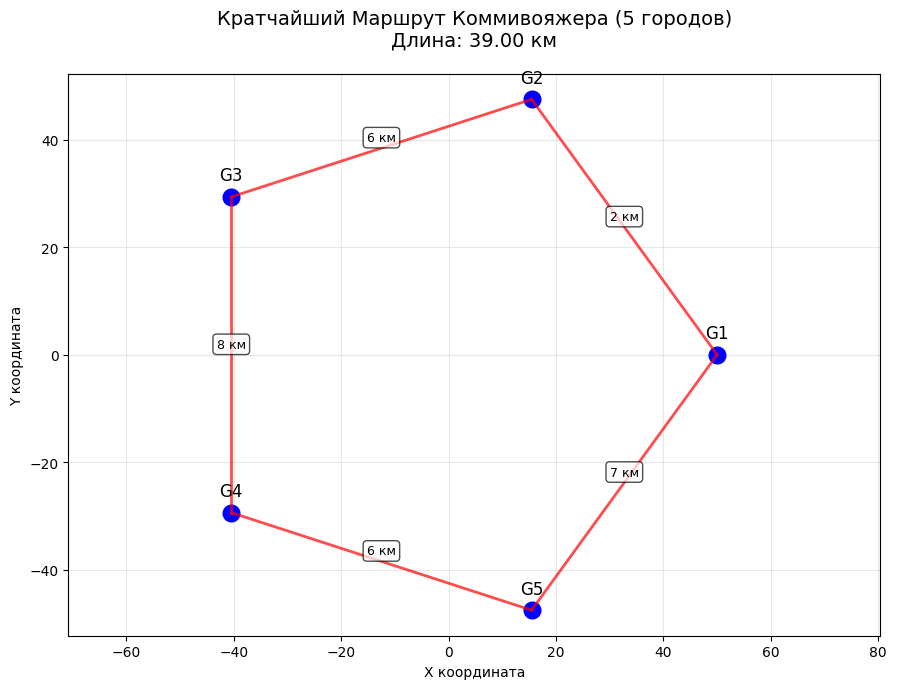


--- Детали маршрута ---
G1 → G2: 2 км
G2 → G3: 6 км
G3 → G4: 8 км
G4 → G5: 6 км
G5 → G1: 7 км
Суммарная длина: 29 км


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import milp, LinearConstraint, Bounds

# --- Решение задачи коммивояжера для 5 городов ---

# Матрица расстояний для 5 городов из условия
dist_matrix_5_cities = np.array([
    [0, 2, 9, 10, 7],
    [2, 0, 6, 4, 3],
    [9, 6, 0, 8, 5],
    [10, 4, 8, 0, 6],
    [7, 3, 5, 6, 0]
])

N_5 = dist_matrix_5_cities.shape[0]  # Количество городов = 5

print("Матрица расстояний (5 городов):")
print(dist_matrix_5_cities)

# --- Формулировка задачи ILP для TSP с MTZ для 5 городов ---

num_x_vars_5 = N_5 * N_5
num_u_vars_5 = N_5 - 1  # u_i для городов 1..N-1
num_total_vars_5 = num_x_vars_5 + num_u_vars_5

# Целевая функция: минимизировать сумму d_ij * x_ij
c_5 = np.zeros(num_total_vars_5)
for i in range(N_5):
    for j in range(N_5):
        if i != j:
            var_idx = i * N_5 + j
            c_5[var_idx] = dist_matrix_5_cities[i, j]

# --- Ограничения ---
constraints_A_rows_5 = []
constraints_b_values_5 = []

# 1. Из каждого города выезжает ровно одна дорога (sum_j x_ij = 1)
for i in range(N_5):
    row = np.zeros(num_total_vars_5)
    for j in range(N_5):
        if i != j:
            var_idx = i * N_5 + j
            row[var_idx] = 1
    constraints_A_rows_5.append(row)
    constraints_b_values_5.append(1)

# 2. В каждый город приезжает ровно одна дорога (sum_i x_ij = 1)
for j in range(N_5):
    row = np.zeros(num_total_vars_5)
    for i in range(N_5):
        if i != j:
            var_idx = i * N_5 + j
            row[var_idx] = 1
    constraints_A_rows_5.append(row)
    constraints_b_values_5.append(1)

# 3. MTZ ограничения: u_i - u_j + N * x_ij >= 1 (для i, j от 1 до N-1, i != j)
for i_idx in range(1, N_5):  # Города 1..N-1
    for j_idx in range(1, N_5):  # Города 1..N-1
        if i_idx != j_idx:
            row = np.zeros(num_total_vars_5)
            # u_i: индекс N*N + (i_idx - 1)
            var_u_i_idx = num_x_vars_5 + (i_idx - 1)
            # u_j: индекс N*N + (j_idx - 1)
            var_u_j_idx = num_x_vars_5 + (j_idx - 1)
            # x_ij: индекс i_idx * N_5 + j_idx
            var_x_ij_idx = i_idx * N_5 + j_idx

            row[var_u_i_idx] = 1
            row[var_u_j_idx] = -1
            row[var_x_ij_idx] = N_5

            constraints_A_rows_5.append(row)
            constraints_b_values_5.append(1)  # >= 1

# --- Типы переменных ---
integrality_5 = np.zeros(num_total_vars_5)
integrality_5[:num_x_vars_5] = 1  # x_ij - бинарные
integrality_5[num_x_vars_5:] = 1  # u_i - целочисленные

# --- Пределы для переменных (Bounds) ---
low_bounds_5 = np.zeros(num_total_vars_5)
up_bounds_5 = np.ones(num_total_vars_5)

low_bounds_5[num_x_vars_5:] = 1  # Нижняя граница для u_i = 1
up_bounds_5[num_x_vars_5:] = N_5  # Верхняя граница для u_i = N

bounds_5 = Bounds(lb=low_bounds_5, ub=up_bounds_5)

# --- Создание объекта LinearConstraint ---
A_all_5 = np.array(constraints_A_rows_5)
b_all_5 = np.array(constraints_b_values_5)
linear_constraint_5 = LinearConstraint(A_all_5, lb=b_all_5)

# --- Решение задачи MILP для 5 городов ---
print("\nРешение задачи коммивояжера (5 городов)...")
result_5 = milp(c=c_5,
                constraints=linear_constraint_5,
                integrality=integrality_5,
                bounds=bounds_5)

# --- Обработка и вывод результатов для 5 городов ---
print("\n--- Результаты для 5 городов ---")
print("Статус решения:", result_5.status)

if result_5.success:
    print("\nОптимальное решение найдено.")

    # Извлечение вектора x_ij
    x_vars_5 = result_5.x[:num_x_vars_5].reshape((N_5, N_5))
    # Извлечение вектора u_i
    u_vars_5 = result_5.x[num_x_vars_5:]

    # --- Восстановление маршрута ---
    route_5 = []
    current_city = 0  # Начинаем с города 0 (G1)
    visited_5 = [False] * N_5

    route_5.append(current_city)
    visited_5[current_city] = True

    # Находим следующий город, пока не посетим все N городов
    for _ in range(N_5 - 1):  # Идем N-1 шагов, чтобы посетить остальные города
        found_next = False
        for next_city in range(N_5):
            # Ищем x_current_city, next_city = 1 и next_city еще не посещен
            if np.isclose(x_vars_5[current_city, next_city], 1) and not visited_5[next_city]:
                current_city = next_city
                route_5.append(current_city)
                visited_5[current_city] = True
                found_next = True
                break
        if not found_next and len(route_5) < N_5:
            print("Ошибка: Не удалось восстановить полный маршрут. Проверьте ограничения.")
            break

    # Добавляем финальный шаг обратно в начальный город
    route_5.append(0)

    total_distance_5 = result_5.fun

    # Преобразуем индексы в названия городов G1, G2, ...
    route_names = [f'G{city+1}' for city in route_5]

    print(f"Кратчайший маршрут: {route_names}")
    print(f"Общая длина маршрута: {total_distance_5:.2f} км")

    # --- Визуализация маршрута для 5 городов ---
    angles_5 = np.linspace(0, 2 * np.pi, N_5, endpoint=False)
    radii_5 = 50
    artificial_coords_5 = np.array([
        radii_5 * np.cos(angles_5),
        radii_5 * np.sin(angles_5)
    ]).T

    plt.figure(figsize=(9, 7))
    plt.plot(artificial_coords_5[:, 0], artificial_coords_5[:, 1], 'o', markersize=12,
             label='Города', color='blue')

    # Подписи городов
    for i in range(N_5):
        plt.annotate(f'G{i+1}', (artificial_coords_5[i, 0], artificial_coords_5[i, 1]),
                     textcoords="offset points", xytext=(0,12), ha='center', fontsize=12)

    # Рисуем линии маршрута
    for i in range(len(route_5) - 1):
        start_city = route_5[i]
        end_city = route_5[i+1]
        distance = dist_matrix_5_cities[start_city, end_city]
        plt.plot([artificial_coords_5[start_city, 0], artificial_coords_5[end_city, 0]],
                 [artificial_coords_5[start_city, 1], artificial_coords_5[end_city, 1]],
                 'r-', alpha=0.7, linewidth=2)

        # Подписи расстояний на ребрах
        mid_x = (artificial_coords_5[start_city, 0] + artificial_coords_5[end_city, 0]) / 2
        mid_y = (artificial_coords_5[start_city, 1] + artificial_coords_5[end_city, 1]) / 2
        plt.annotate(f'{distance} км', (mid_x, mid_y),
                     textcoords="offset points", xytext=(0,5), ha='center',
                     fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    plt.title(f'Кратчайший Маршрут Коммивояжера (5 городов)\nДлина: {total_distance_5:.2f} км',
              fontsize=14, pad=20)
    plt.xlabel('X координата')
    plt.ylabel('Y координата')
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # --- Детализация маршрута ---
    print("\n--- Детали маршрута ---")
    total_calc = 0
    for i in range(len(route_5) - 1):
        start = route_5[i]
        end = route_5[i+1]
        dist = dist_matrix_5_cities[start, end]
        total_calc += dist
        print(f"G{start+1} → G{end+1}: {dist} км")

    print(f"Суммарная длина: {total_calc} км")

else:
    print("Решение не было найдено.")
    print("Сообщение об ошибке:", result_5.message)